# Классификация отзывов клиентов М-Видео
___

In [ ]:
import numpy as np

import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_style('whitegrid')
import scipy

# подсчет числа ядер в процессоре
import multiprocessing
cores = multiprocessing.cpu_count()

<ipython-input-39-964f4c3c22df>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Загрузка данных

In [ ]:
orig_data = pd.read_csv('data.csv', sep=';')
data = orig_data.copy()
data

,text,class
0,Невнимательность к покупателю. Товар выносят после оплаты не распечатывая и не проверяя ( даже не предлагают проверить целостность и комплектацию товара.),Товар
1,Посудомоечная машина не исправна. Остальной товар ещё не проверяла,Товар
2,"Приехал в магазин, оказался только Витринный образец",Товар
3,Несколько раз переносили дату доставки.,Доставка
4,"На сайте было написано бесплатная доставка,а по факту оказалось, что надо заплатить за неё.",Доставка
...,...,...
1758,"Товар с витрины..считаю что на такие вещи положена скидка, которой конечно нет_x000D_\nНастроение испорчено всеми этими моментами",Товар
1759,Доставили не тот товар,Доставка
1760,Была очень долгая доставка до магазина.,Доставка
1761,"Верхняя прорезиненная часть термобутылки (не упаковки, а самого товара) была загрязнена пылью. Не фатально, не неприятно. Вероятно стоит улучшить условия хранения",Товар


## Предварительный анализ данных

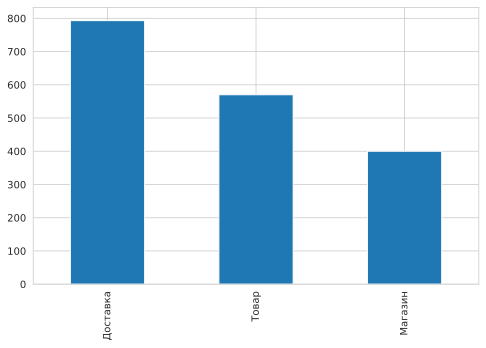

In [ ]:
# посмотрим на распределение отзывов по категориям
data['class'].value_counts().plot(kind='bar');

## Подготовка данных

Для подготовки данных напишем функцию <code> data_prep</code>, которая берет на вход <code>pandas.Series</code> с отзывами клиентов и с каждым отзывом выполняет следующие шаги:
1. удаляет повторяющийся символ '_x000D_';
2. удаляет знаки препинания;
3. заменяет все символы табуляции на пробел;
4. приводит текст к нижнему регистру;
5. удаляет стоп-слова (библиотека nltk);
6. проверяет правописание (библиотека enchant с добавленным словарем русского языка)
7. приводит все слова к исходной форме (библиотека pymorphy2)

Дальнейшее исследование показало, что проверка правописания не вносит принципиальных положительных изменений в результаты классификации, поэтому из-за медлительности этот пункт был закомментирован.

In [ ]:
import re
import nltk
!pip3 install pymorphy2

In [ ]:
def data_prep(series):
    # удаление повторяющегося символа _x000D_d
    series = series.str.replace('_x000D_', '')

    # удаление знаков препинания
    series = series.str.replace('[^\w\s]', ' ', regex=True)

    # замена всех символов табуляции на пробел
    series = series.str.replace('\s+', ' ', regex=True)

    # приведение всего текста к нижнему регистру
    series = series.str.lower()

    # удаление стоп-слов
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('russian'))
    series = series.apply(
        lambda review: ' '.join([word for word in review.split() if word not in stop_words]))

    # проверка правописания
    # from enchant.checker import SpellChecker
    # chkr = SpellChecker('ru_RU')

    # def spelling_corrector(sentence):
    #     chkr.set_text(sentence)
    #     for err in chkr:
    #         if len(err.suggest()) > 0:
    #             sug = err.suggest()[0]
    #             err.replace(sug)

    #     return chkr.get_text()
        
    # series = series.apply(spelling_corrector)

    # лемматизация
    import pymorphy2
    morph = pymorphy2.MorphAnalyzer()

    def lemmatizer(sentence):
        words = sentence.split()
        normal_words = [
            morph.parse(word)[0].normal_form
            for word in words
        ]
        return ' '.join(normal_words)

    series = series.apply(lemmatizer)

    return series

In [ ]:
data['text'] = data_prep(data['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Создание новых признаков

Для дальнейшей работы с данными заменим тип таргета с текстового на числовой и добавим новые признаки:
- количество слов в отзыве;
- количество символов в отзыве.

In [ ]:
# заменим название класса числом
class_dict = {
    'Доставка': 0,
    'Товар': 1,
    'Магазин': 2
}
data['class'] = data['class'].map(class_dict)

# добавим количество слов в отзыве
data['word_count'] = data['text'].map(lambda review: len(review.split()))

# добавим количество символов в отзыве
data['char_count'] = data['text'].map(lambda review: len(review))

In [ ]:
# поменяем столбцы местами, чтобы таргет был последним
data = data[['text', 'word_count', 'char_count', 'class']]

# выгрузим преодобработанные данные в csv
data.to_csv(path_or_buf='preprocessed_data.csv', sep=';', index=False)

In [ ]:
# загрузка предварительно обработанных данных
preprocessed_data = pd.read_csv('preprocessed_data.csv', sep=';')
preprocessed_data

,text,word_count,char_count,class
0,невнимательность покупатель товар выносить оплата распечатывать проверять предлагать проверить целостность комплектация товар,12,125,1
1,посудомоечный машина исправный остальной товар ещё проверять,7,60,1
2,приехать магазин оказаться витринный образец,5,44,1
3,несколько переносить дата доставка,4,34,0
4,сайт написать бесплатный доставка факт оказаться заплатить она,8,62,0
...,...,...,...,...
1758,товар витрина считать такой вещь положить скидка который настроение испортить весь этот момент,13,94,1
1759,доставить товар,2,15,0
1760,очень долгий доставка магазин,4,29,0
1761,верхний прорезиненный часть термобутылка упаковка сам товар загрязнить пыль фатально неприятно вероятно стоить улучшить условие хранение,16,136,1


## Разделение данных на тренировочные и валидационные

In [ ]:
from sklearn.model_selection import train_test_split

X = preprocessed_data.drop(columns=['class'])
y = preprocessed_data['class']

# stratify=y сохраняет пропорции классов
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.2, stratify=y)

## Векторизация

Для дальнейшей работы с отзывами необходимо закодировать текстовую информацию числами (процесс векторизации). Будем использовать 4 способа векторизации:
1. bag of words;
2. TF-IDF;
3. word2vec;
4. fast text.

### BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# создаем трансформер и кормим его тренировочными данными
bow = CountVectorizer()
bow.fit(X_train['text'])

# преобразуем тренировочные и валидационные данные 
# не забываем добавить колонки с количеством слов и символов
X_train_bow = np.hstack((
    bow.transform(X_train['text']).toarray(),       # vectorized 'text' column
    X_train.drop(columns=['text']).to_numpy()))     # remaining columns

X_valid_bow = np.hstack((
    bow.transform(X_valid['text']).toarray(),          
    X_valid.drop(columns=['text']).to_numpy()))        

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# создаем трансформер и кормим его тренировочными данными
tfidf = TfidfVectorizer()
tfidf.fit(X_train['text'])

# преобразуем тренировочные и валидационные данные 
# не забываем добавить колонки с количеством слов и символов
X_train_tfidf = np.hstack((
    tfidf.transform(X_train['text']).toarray(),
    X_train.drop(columns=['text']).to_numpy()))

X_valid_tfidf = np.hstack((
    tfidf.transform(X_valid['text']).toarray(),          
    X_valid.drop(columns=['text']).to_numpy()))     

### Word2Vec

In [ ]:
from gensim.models import Word2Vec

# создаем списки слов из отзывов
tokenized_reviews = [review.split() for review in X['text']]

# создаем модель с определенными параметрами
w2v = Word2Vec(
    min_count=10,       # минимальная частота для учитывания слова
    window=3,           # макс. расстояние между данным и предсказываемым словом
    vector_size=300,    # размерность векторов слов
    workers=cores-1)    # распараллеливание вычислений

# создание вокабуляра
w2v.build_vocab(tokenized_reviews)

# тренировка модели на имеющихся данных
w2v.train(
    tokenized_reviews,
    total_examples=w2v.corpus_count,
    epochs=30);

In [ ]:
# проверим, как работает модель по предсказанию наиболее похожих слов
w2v.wv.most_similar(positive=['товар'])

[('оплата', 0.9613602161407471),
 ('продажа', 0.9471420049667358),
 ('оказаться', 0.9424616694450378),
 ('никакой', 0.9393869042396545),
 ('цена', 0.9392712712287903),
 ('наличие', 0.9390107989311218),
 ('продать', 0.933259129524231),
 ('витрина', 0.9331103563308716),
 ('продавать', 0.9210062623023987),
 ('ассортимент', 0.9189660549163818)]

In [ ]:
# функция по векторизации отзывов (через усреднение векторов слов)
def w2v_vectorize(review):
    words = review.split()
    words_vecs = [w2v.wv[word] for word in words if word in w2v.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
# преобразуем тренировочные и валидационные данные 
# не забываем добавить колонки с количеством слов и символов

X_train_w2v = X_train['text'].map(w2v_vectorize)
X_train_w2v = pd.DataFrame(X_train_w2v.tolist(), index=X_train_w2v.index)
X_train_w2v = np.hstack((
    X_train_w2v.to_numpy(),
    X_train.drop(columns=['text']).to_numpy()))

X_valid_w2v = X_valid['text'].map(w2v_vectorize)
X_valid_w2v = pd.DataFrame(X_valid_w2v.tolist(), index=X_valid_w2v.index)
X_valid_w2v = np.hstack((
    X_valid_w2v.to_numpy(),
    X_valid.drop(columns=['text']).to_numpy()))

### FastText

In [ ]:
from gensim.models import FastText

# создаем списки слов из отзывов
tokenized_reviews = [review.split() for review in X['text']]

# создаем модель с определенными параметрами
ft = FastText(
    min_count=10,       # минимальная частота для учитывания слова
    window=3,           # макс. расстояние между данным и предсказываемым словом
    vector_size=300,    # размерность векторов слов
    workers=cores-1)    # распараллеливание вычислений

# создание вокабуляра
ft.build_vocab(tokenized_reviews)

# тренировка модели на имеющихся данных
ft.train(
    tokenized_reviews,
    total_examples=ft.corpus_count,
    epochs=30);

In [ ]:
# проверим, как работает модель по предсказанию наиболее похожих слов
ft.wv.most_similar(positive=['доставка'])

[('доставщик', 0.9921966791152954),
 ('доставить', 0.9791281223297119),
 ('дом', 0.9727096557617188),
 ('доставлять', 0.9613491892814636),
 ('назначить', 0.9596459865570068),
 ('курьер', 0.9588374495506287),
 ('9', 0.9576639533042908),
 ('дозвониться', 0.9566860198974609),
 ('звонок', 0.9562077522277832),
 ('12', 0.9538450241088867)]

In [ ]:
# функция по векторизации отзывов (через усреднение векторов слов)
def ft_vectorize(review):
    words = review.split()
    words_vecs = [ft.wv[word] for word in words]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
# преобразуем тренировочные и валидационные данные 
# не забываем добавить колонки с количеством слов и символов

X_train_ft = X_train['text'].map(ft_vectorize)
X_train_ft = pd.DataFrame(X_train_ft.tolist(), index=X_train_ft.index)
X_train_ft = np.hstack((
    X_train_ft.to_numpy(),
    X_train.drop(columns=['text']).to_numpy()))

X_valid_ft = X_valid['text'].map(ft_vectorize)
X_valid_ft = pd.DataFrame(X_valid_ft.tolist(), index=X_valid_ft.index)
X_valid_ft = np.hstack((
    X_valid_ft.to_numpy(),
    X_valid.drop(columns=['text']).to_numpy()))

## Классические модели

Для решения задачи классификации воспользуемся тремя классическими моделями:
1. наивный Байесовский классификатор;
2. логистическая регрессия;
3. градиентный бустинг.

In [ ]:
# метрика для оценки качества -- f1-score
from sklearn.metrics import f1_score

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

def nbayes_predict(X_train, y_train, X_valid):
    nbayes = GaussianNB()
    nbayes.fit(X_train, y_train)
    preds = nbayes.predict(X_valid)
    return f1_score(y_valid, preds, average='macro')

In [ ]:
nbayes_bow_score = nbayes_predict(X_train_bow, y_train, X_valid_bow)
nbayes_tfidf_score = nbayes_predict(X_train_tfidf, y_train, X_valid_tfidf)
nbayes_w2v_score = nbayes_predict(X_train_w2v, y_train, X_valid_w2v)
nbayes_ft_score = nbayes_predict(X_train_ft, y_train, X_valid_ft)

In [ ]:
nbayes_bow_score, nbayes_tfidf_score, nbayes_w2v_score, nbayes_ft_score

(0.7413116232315952, 0.784948829805094, 0.8215674694315025, 0.784859260414884)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def logreg_predict(X_train, y_train, X_valid):
    # удалим последние два столбца,
    # которые отвечают за количество слов и количество символов
    # практика показывает, что логистическая регрессия работает лучше
    # без этих признаков
    X_train_clean = X_train[::, :-2]
    X_valid_clean = X_valid[::, :-2]

    logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
    logreg.fit(X_train_clean, y_train)
    preds = logreg.predict(X_valid_clean)
    return f1_score(y_valid, preds, average='macro')

In [ ]:
logreg_bow_score = logreg_predict(X_train_bow, y_train, X_valid_bow)
logreg_tfidf_score = logreg_predict(X_train_tfidf, y_train, X_valid_tfidf)
logreg_w2v_score = logreg_predict(X_train_w2v, y_train, X_valid_w2v)
logreg_ft_score = logreg_predict(X_train_ft, y_train, X_valid_ft)

In [ ]:
logreg_bow_score, logreg_tfidf_score, logreg_w2v_score, logreg_ft_score

(0.9285291106467954,
 0.9455397543632839,
 0.8726005412105321,
 0.8090613998884445)

### XGBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# подберем лучшие параметры для нашей модели,
# используя TF-IDF векторизацию

gb_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1]}

gb = GradientBoostingClassifier(n_iter_no_change=5)

gb_grid_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_params,
    scoring='f1_micro',
    cv=5,
    n_jobs=cores-1,
    verbose=3)

gb_grid_search.fit(X_train_tfidf, y_train)

In [ ]:
gb_grid_search.best_params_

In [ ]:
def gb_predict(X_train, y_train, X_valid):
    gb = GradientBoostingClassifier(
        n_iter_no_change=5,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1)
    
    gb.fit(X_train, y_train)
    preds = gb.predict(X_valid)
    return f1_score(y_valid, preds, average='macro')

In [ ]:
gb_bow_score = gb_predict(X_train_bow, y_train, X_valid_bow)
gb_tfidf_score = gb_predict(X_train_tfidf, y_train, X_valid_tfidf)
gb_w2v_score = gb_predict(X_train_w2v, y_train, X_valid_w2v)
gb_ft_score = gb_predict(X_train_ft, y_train, X_valid_ft)

In [ ]:
gb_bow_score, gb_tfidf_score, gb_w2v_score, gb_ft_score

(0.9008498583569405,
 0.8951841359773371,
 0.8611898016997167,
 0.7960339943342775)

### Сводная таблица результатов моделирования

In [ ]:
pd.DataFrame({
    'BoW' : [nbayes_bow_score, logreg_bow_score, gb_bow_score],
    'TF-IDF' : [nbayes_tfidf_score, logreg_tfidf_score, gb_tfidf_score],
    'Word2Vec' : [nbayes_w2v_score, logreg_w2v_score, gb_w2v_score],
    'FastText' : [nbayes_ft_score, logreg_ft_score, gb_ft_score]
}, index=['Naive Bayes', 'Logistic Regression', 'Gradient Boosting'])

,BoW,TF-IDF,Word2Vec,FastText
Naive Bayes,0.801700,0.796034,0.818697,0.801700
Logistic Regression,0.934844,0.960340,0.852691,0.832861
Gradient Boosting,0.900850,0.895184,0.861190,0.796034


Как видно из таблицы наилучшие результаты показывает комбинация TF-IDF векторизации с логистической регрессией.

## Полносвязная нейронная сеть для классификации отзывов

Построим полносвязную нейросеть для решения задачи классификации с помощью PyTorch и PyTorchLightning

### Загрузка необходимых библиотек и функций

In [ ]:
# установим Pytorch Lightning для упрощения написания нейронной сети
!pip3 install pytorch_lightning torchmetrics

In [ ]:
# установим необходимые библиотеки
import torch
from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score

# задаем метрику для оценки качества модели
f1 = MulticlassF1Score(num_classes=3, average='macro')

In [ ]:
# задаем девайс, на котором будут проводиться вычисления
# если на машине есть gpu, то вычисления лучше проводить на нем, т.к. это быстрее

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

### Преобразование данных в DataLoader

Для корректной оценки качества нейросети необходимо выделить тестовый датасет, который не будет доступен в процессе обучения. Для этого в процессе создания DataLoaders отделим половину валидационного датасета.

In [ ]:
def create_detaloaders(vectorization):
    if vectorization == 'bow':
        X_train = X_train_bow
        X_valid, X_test, y_val, y_test = \
            train_test_split(X_valid_bow, y_valid, test_size=0.5, stratify=y_valid)

    elif vectorization == 'tfidf':
        X_train = X_train_tfidf
        X_valid, X_test, y_val, y_test = \
            train_test_split(X_valid_tfidf, y_valid, test_size=0.5, stratify=y_valid)

    elif vectorization == 'w2v':
        X_train = X_train_w2v
        X_valid, X_test, y_val, y_test = \
            train_test_split(X_valid_w2v, y_valid, test_size=0.5, stratify=y_valid)
    
    elif vectorization == 'ft':
        X_train = X_train_ft
        X_valid, X_test, y_val, y_test = \
            train_test_split(X_valid_ft, y_valid, test_size=0.5, stratify=y_valid)
    else:
        raise ValueError

    # преобразуем данные из numpy.ndarray в torch.tensor
    X_train_tensor = torch.Tensor(X_train)
    X_valid_tensor = torch.Tensor(X_valid)
    X_test_tensor = torch.Tensor(X_test)

    y_train_tensor = torch.LongTensor(y_train.to_numpy())
    y_valid_tensor = torch.LongTensor(y_val.to_numpy())
    y_test_tensor = torch.LongTensor(y_test.to_numpy())

    # создадим Tensor Dataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # создадим DataLoader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=cores)

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=64,
        num_workers=cores)
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=64,
        num_workers=cores)
    
    return train_dataloader, valid_dataloader, test_dataloader, X_train.shape[1]

Зададим такие гиперпараметры сети, как способ векторизации, количество эпох обучения и learnign rate

In [ ]:
# гиперпараметры
VEC = 'bow'
EPOCHS = 30
LR = 0.001

# создание DataLoaders на основе выбранной векторизации
train_dataloader, valid_dataloader, test_dataloader, n_cols = \
    create_detaloaders(vectorization=VEC)

### Класс, определяющий архитектуру нейронной сети

Создадим нейросеть с простой архитектурой: один скрытый линейный слой с 128 нейронами и функцией активации ReLU

In [ ]:
class NetArchitecture(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(n_cols, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 3)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

    def forward(self, reviews, target=None):
        output = self._forward(reviews)
        
        if target is not None:
            loss = self.loss_func(output, target)
            return output, loss

        return output

### Класс, определяющий процесс обучения нейронной сети

In [ ]:
class NetModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        reviews, target = train_batch
        _, loss = self.model(reviews, target)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, valid_batch, batch_idx):
        reviews, target = valid_batch
        _, loss = self.model(reviews, target)
        self.log('valid_loss', loss, prog_bar=True)

    def test_step(self, test_batch, batch_idx):
        reviews, target = test_batch
        preds = self.model(reviews)
        pred_classes = torch.argmax(preds, dim=-1)
        score = f1(pred_classes.cpu(), target.cpu()).mean()
        self.log('test_f1_score', score, prog_bar=True)

### Обучение модели

In [ ]:
model = NetArchitecture().to(device)
module = NetModule(
    model,
    learning_rate=LR)

trainer = pl.Trainer(
    accelerator=accelerator,
    max_epochs=EPOCHS)

trainer.fit(module, train_dataloader, valid_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | NetArchitecture | 414 K 
------------------------------------------
414 K     Trainable params
0         Non-trainable params
414 K     Total params
1.660     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


### Тестирование и анализ качества модели

In [ ]:
trainer.test(module, dataloaders=test_dataloader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_score       │    0.9378530979156494     │
└───────────────────────────┴───────────────────────────┘

[{'test_f1_score': 0.9378530979156494}]

Исследование показывает, что налучших результатов классификации удается достичь при следующих параметрах:
- BoW векторизация;
- 30 эпох обучения;
- learning rate = 0.01.
Так же исследование показало, что усложнение структуры сети (увеличение количества нейронов на скрытых слоях и увеличение числа скрытых слоев) не дает принципиальных улучшений в классификации, а иногда приводит только к ухудшению за счет переобучения.

## Выводы

Проведенное исследование показало, что для поставленной задачи классификации отзывов магазина на категории "доставка", "товар" и "магазин" лучше всего подошла комбинация TF-IDF векторизации с логистической регрессией. Такая комбинация устойчиво дает результат метрики f1 около 0.94.
Результаты с более сложными моделями векторизации такими как Word2Vec и FastText оказались хуже. Возможно это вызвано небольшим размером выборки, на котором модели обучались (1400 документов).

Построение полносвязной нейросети также не позволило улучшить качество (при лучшей комбинации параметров удалось добиться такого же результата в 0.94).

Возможные пути для дальнейшего улучшения качества модели могут заключаться в использовании уже предобученных моделей векторизации Word2Vec и FastText на больших текстовых данных.

## Сохранение лучшей модели

Как было сказано выше, лучшие результаты показала комбинация TF-IDF векторизации с логистической регрессией. Именно эту модель мы сохраним в отдельный файл для дальнейшего использования.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip3 install pymorphy2
import pymorphy2

In [ ]:
# создадим пайплайн векторизации TF-IDF и логистической регрессии
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

In [ ]:
# обучим модель на предобработанных данных
pipe.fit(preprocessed_data['text'], y)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# сохраним модель с помощью модуля pickle
import pickle

with open('model_pkl', 'wb') as file:
    pickle.dump(pipe, file)